In [110]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [111]:
import filter_utils as filt

In [112]:
data_dir = "./data/"
data_fn = data_dir + "cleaned_data.txt"
data_grey_fn = data_dir + "cleaned_grey_values.txt"

In [113]:
all_elements = pd.read_csv(data_fn)
print(all_elements.head())

   Distance (um)  Elapsed Time   B11_ppm  Na23_ppm  Mg25_ppm  Al27_ppm  \
0      -1.483983     -1.483983 -0.000987 -1.739987  1.252779 -1.428722   
1      -1.478071     -1.478071  0.273978 -0.963147  2.358353 -1.189735   
2      -1.472164     -1.472164 -0.041514 -1.274842  1.587131 -0.879393   
3      -1.466252     -1.466252  0.646814 -0.961113  1.437627 -1.582681   
4      -1.460344     -1.460344  0.151465 -1.214546  1.474992 -1.570397   

   Si28_ppm   P31_ppm   S34_ppm  Cl35_ppm  ...  Zn66_ppm  Zn68_ppm  Sr88_ppm  \
0 -1.030042  1.095407  0.576121 -1.078462  ...  1.409131  1.572304  1.231484   
1 -0.483173  1.588047  1.585102 -1.104329  ...  1.439062  1.372410  0.979279   
2 -0.694485  1.389658  0.317097 -0.880657  ...  1.674240  1.736563  0.941318   
3 -1.052700  1.525399 -0.236500 -1.136729  ...  1.628649  1.488895 -0.189878   
4 -1.296695  1.237596 -0.067184 -1.486543  ...  1.335298  1.297910  0.958900   

   Ba138_ppm  PbTotal_ppm     pixel  new_distance  new_pixel  case  sex  


In [114]:
grey_values = pd.read_csv(data_grey_fn)
print(grey_values)

      Distance_(pixels)  Gray_Value  new_pixel  case  cleaned_grey sex
0                   432    126.7965          0    43      4.842583   M
1                   433    126.2878          1    43      4.838563   M
2                   434    123.3846          2    43      4.815306   M
3                   435    120.0393          3    43      4.787819   M
4                   436    118.5882          4    43      4.775657   M
...                 ...         ...        ...   ...           ...  ..
5678               1746    104.8251       1480    56      4.631919   F
5679               1747    104.6929       1481    56      4.631425   F
5680               1748    103.3024       1482    56      4.637661   F
5681               1749    101.6086       1483    56      4.621128   F
5682               1750    101.0000       1484    56      4.615121   F

[5683 rows x 6 columns]


In [115]:
elt_name = "S34_ppm" # "Sr88_ppm" # "Mg25_ppm" # "Cu65_ppm" # "Zn66_ppm" # 
elt_array = [
    all_elements[all_elements['case']==i][elt_name] for i in [43,44,55,56]
]
print([len(arr) for arr in elt_array])

[461, 320, 570, 711]


i=1, px=0.1500000111532847
i=2, px=0.127500009480292
i=3, px=0.10837500805824818
i=4, px=0.09211875684951096
i=5, px=0.07830094332208432
i=6, px=0.06655580182377167
i=7, px=0.056572431550205915
i=8, px=0.04808656681767502
i=9, px=0.040873581795023775
i=10, px=0.034742544525770205
i=11, px=0.02953116284690467
i=12, px=0.025101488419868968
i=13, px=0.021336265156888624
i=14, px=0.01813582538335533
i=15, px=0.01541545157585203
i=16, px=0.013103133839474226
i=17, px=0.011137663763553091
i=18, px=0.009467014199020128
i=19, px=0.008046962069167109
i=20, px=0.006839917758792042
i=21, px=0.005813930094973235
i=22, px=0.00494184058072725
i=23, px=0.004200564493618162
i=24, px=0.003570479819575438
i=25, px=0.003034907846639122
i=26, px=0.002579671669643254
i=27, px=0.002192720919196766
i=28, px=0.0018638127813172508
i=29, px=0.0015842408641196632
i=30, px=0.0013466047345017137
i=31, px=0.0011446140243264566
i=32, px=0.0009729219206774881
i=33, px=0.0008269836325758648
i=34, px=0.0007029360876894

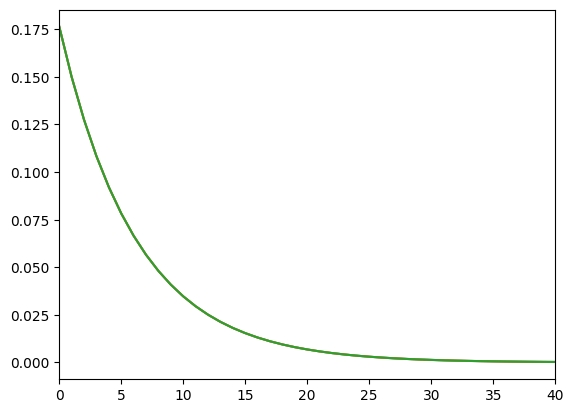

In [ ]:
bandwidth = 100
mortality_rate = 0.15

def truncated_geometric_pdf(p: float, k: int, n: int = bandwidth) -> float:
    if k < 0 or n < 0:
        return 0.0
    return p * (1 - p)**(k-1) / (1 - (1 - p)**(n+1))

def prior1(x: np.ndarray, p: float = mortality_rate) -> np.ndarray:
    # Find the idx of the max True element.
    # This is the index of the highest frequency basis function included.
    # This is a proxy for age since age is the number of peaks and the 
    # highest frequency basis function has the most peaks of all basis functions.
    # (This is not a perfect proxy since a combination of lower frequency
    # basis functions can produce more peaks than a single high frequency)
    idx = -1
    for i in range(len(x)-1, -1, -1):
        if x[i]:
            idx = i
            break
    return truncated_geometric_pdf(p, i)

def prior2(x: np.ndarray, p: float = mortality_rate) -> np.ndarray:
    # Sum the frequencies of all basis functions.
    # This is a proxy for age since age is the number of peaks which is
    # at most the sum of all frequencies.
    s = 0
    for i in range(len(x)):
        s += i * x[i]
    return truncated_geometric_pdf(p, s)

# Assume that the mortality rate is 20% per year => p=0.8, prior prob of age s is 0.8^s.
def prior(x= np.ndarray, p=mortality_rate, q=0.9) -> np.ndarray:
    return prior1(x,p)*q + prior2(x,p)*(1-q)

xi = range(0, bandwidth+1)
xv = np.eye(bandwidth+1)
p1x = [prior1(xv[i]) for i in range(len(xv))]
p2x = [prior2(xv[i]) for i in range(len(xv))]
px = [prior(xv[i]) for i in range(len(xv))]
for i in range(1, len(px)):
    print(f"i={i}, px={px[i]}")
p = plt.figure()
p = plt.plot(xi, p1x, label="prior1")
p = plt.plot(xi, p2x, label="prior2")
p = plt.plot(xi, px, label="prior")
p = plt.xlim(0,40)
p = plt.show()

In [136]:
# threshold = filt.SUBSTANTIAL_DIFFERENCE_IN_MODELS_THRESHOLD # Substantial difference between models required to pick the more complex one.
threshold = filt.SIGNIFICANT_DIFFERENCE_IN_MODELS_THRESHOLD # Strong difference between models required to pick the more complex one.

In [137]:
criterion = "bic" # "aic" or "bic"
mode = "forward" # "forward" or "backward"

0.1500000111532847
0.127500009480292
0.10837500805824818
0.09211875684951096
0.07830094332208432
0.06655580182377167
0.056572431550205915
0.04808656681767502
0.040873581795023775
0.034742544525770205
0.02953116284690467
0.025101488419868968
0.021336265156888624
0.01813582538335533
0.01541545157585203
0.013103133839474226
0.011137663763553091
0.009467014199020128
0.008046962069167109
0.006839917758792042
0.005813930094973235
0.00494184058072725
0.004200564493618162
0.003570479819575438
0.003034907846639122
0.002579671669643254
0.002192720919196766
0.0018638127813172508
0.0015842408641196632
0.0013466047345017137
0.0011446140243264566
0.0009729219206774881
0.0008269836325758648
0.000702936087689485
0.0005974956745360623
0.0005078713233556529
0.00043169062485230497
0.00036693703112445925
0.00031189647645579033
0.00026511200498742174
0.0002253452042393085
0.00019154342360341224
0.0001628119100629004
0.00013839012355346532
0.00011763160502044551
9.998686426737868e-05
8.498883462727187e-05
7

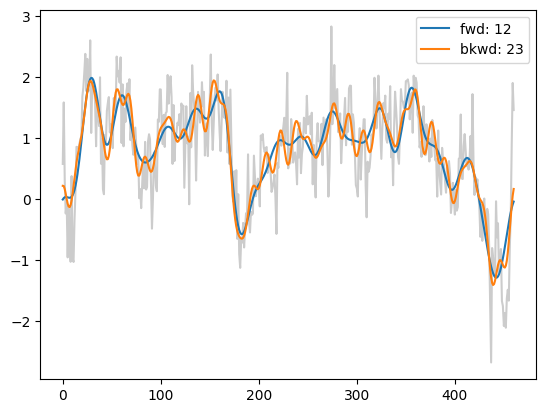

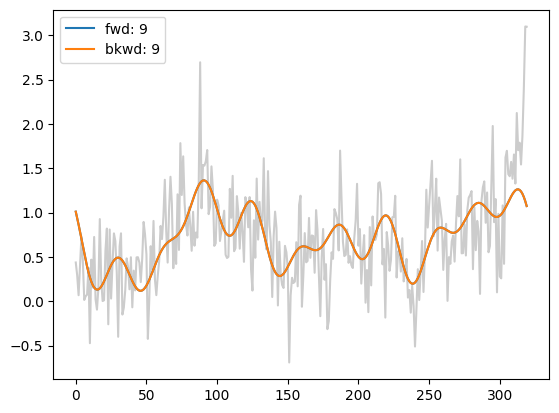

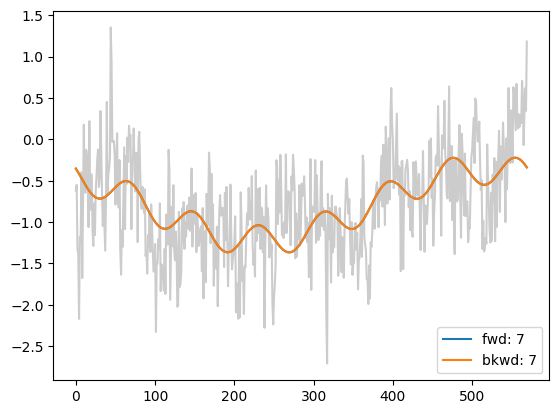

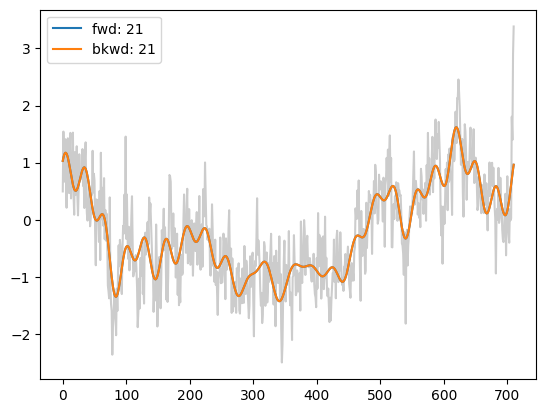

In [138]:
plts = []
fwd_yr_lens_array = []
bkwd_yr_lens_array = []
for i in range(len(elt_array)):
    elt = np.asarray(elt_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        elt, bandwidth, mode, threshold, criterion, prior
    )
    bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
        elt, bandwidth, "backward", threshold, criterion, prior
    )

    p = plt.figure()
    p = plt.plot(range(len(elt)), elt, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


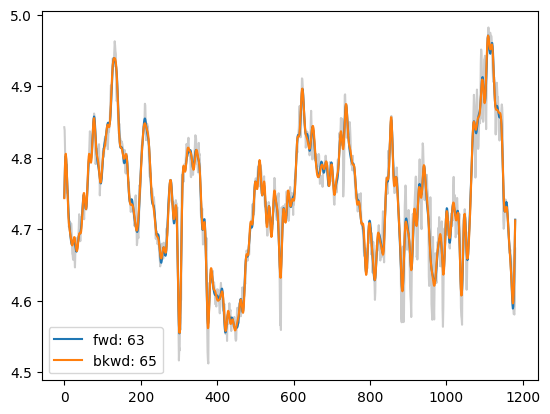

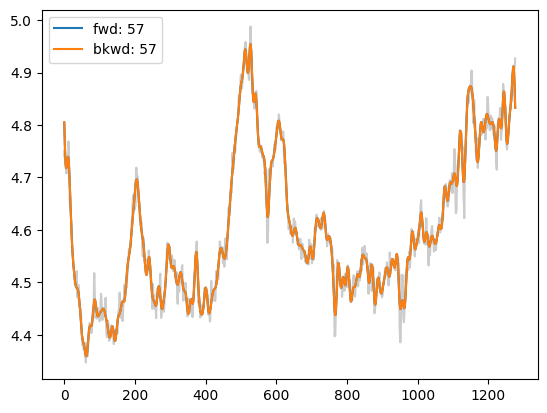

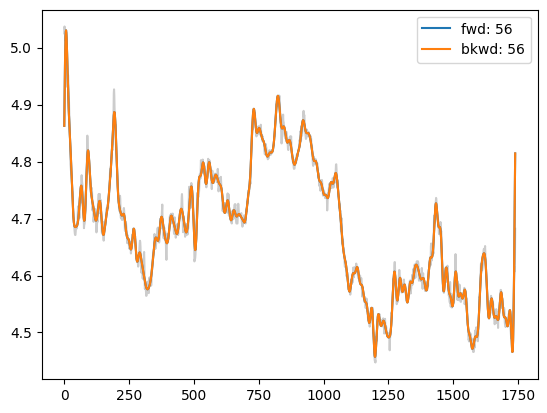

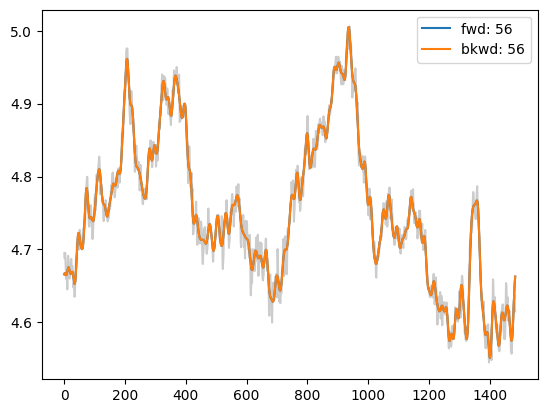

In [120]:
grey_array = [
    grey_values[grey_values['case']==i]['cleaned_grey'] for i in [43,44,55,56]
]
plts = []
for i in range(len(grey_array)):
    grey_val = np.asarray(grey_array[i])
    fwd_count, fwd_locations, fwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "forward",
    )
    bkwd_count, bkwd_locations, bkwd_smoothed = filt.age_shark(
        grey_val, bandwidth, "backward",
    )

    p = plt.figure()
    p = plt.plot(range(len(grey_val)), grey_val, color="grey", alpha=0.4)
    p = plt.plot(fwd_smoothed, label=f"fwd: {fwd_count}")
    p = plt.plot(bkwd_smoothed, label=f"bkwd: {bkwd_count}")
    p = plt.legend()
    
    plts.append(p)

In [121]:
(elt_array[0])

0      0.576121
1      1.585102
2      0.317097
3     -0.236500
4     -0.067184
         ...   
456   -0.822122
457   -0.262803
458    0.886909
459    1.904121
460    1.460023
Name: S34_ppm, Length: 461, dtype: float64